In [3]:
import sys,os,os.path
sys.path.append("../../") # if you move files around, you need to adjust this!
sys.path.append(os.path.expanduser('~/code/eol_hsrl_python'))
os.environ['ICTDIR']='/home/e78368jw/Documents/NEXT_CODE/IC'

#%load_ext autoreload
#%autoreload 2
#%matplotlib notebook

import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams['mathtext.fontset'] = 'stix'
rcParams['font.family'] = 'STIXGeneral'
rcParams['figure.figsize'] = [10, 8]
rcParams['font.size'] = 22

import pandas as pd
import numpy  as np
import tables as tb

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.colors as clrs

import IC.invisible_cities.core.core_functions                   as     coref
import IC.invisible_cities.io.dst_io                           as     dstio

from IC.invisible_cities.cities                 import beersheba as beerfun

from IC.invisible_cities.evm.event_model                          import HitCollection

from IC.invisible_cities.database.load_db       import DataSiPM

from IC.invisible_cities.evm.event_model        import Cluster, Hit
from IC.invisible_cities.types.ic_types         import xy
from IC.invisible_cities.reco.paolina_functions import voxelize_hits

from IC.invisible_cities.evm.event_model        import HitEnergy
from IC.invisible_cities.cities.beersheba          import DeconvolutionMode
from IC.invisible_cities.cities.beersheba          import CutType

from IC.invisible_cities.reco import hits_functions as hif

from IC.invisible_cities.reco.deconv_functions import deconvolve
from IC.invisible_cities.reco.deconv_functions import deconvolution_input
from IC.invisible_cities.reco.deconv_functions import InterpolationMethod

import IC.invisible_cities.io.mcinfo_io as mcio

from collections import defaultdict

import matplotlib.cm as cm
from matplotlib.colors import Normalize



In [48]:

def threshold_hits(threshold_charge, same_peak, hitc):
    """
    Applies a threshold to hits and redistributes the charge/energy.

    Parameters
    ----------
    threshold_charge : float
        minimum pes of a hit
    same_peak        : bool
        whether to reassign NN hits' energy only to the hits from the same peak

    Returns
    ----------
    A function that takes HitCollection as input and returns another object with
    only non NN hits of charge above threshold_charge.
    The energy of NN hits is redistributed among neighbors.
    """

    t = hitc.time
    thr_hits = hif.threshold_hits(hitc.hits, threshold_charge     )
    mrg_hits = hif.merge_NN_hits ( thr_hits, same_peak = same_peak)

    cor_hits = []
    for hit in mrg_hits:
        cluster = Cluster(hit.Q, xy(hit.X, hit.Y), hit.var, hit.nsipm)
        xypos   = xy(hit.Xpeak, hit.Ypeak)
        hit     = Hit(hit.npeak, cluster, hit.Z, hit.E, xypos, hit.Ec)
        cor_hits.append(hit)

    new_hitc      = HitCollection(hitc.event, t)
    new_hitc.hits = cor_hits
    return new_hitc





def hits_from_df (dst, skip_NN = False):
    """
    Function that transforms pandas DataFrame dst to HitCollection
    ------
    Parameters
    ------
    dst : pd.DataFrame
        DataFrame with obligatory columns :
                event, npeak, X, Y, Z,  Q, E
        If time, nsipm, Xrms, Yrms, Qc, Ec, track_id are not
        inside dst the default value is set to -1
        If Xpeak, Ypeak not in dst the default value is -1000
    ------
    Returns
    ------
    Dictionary {event_number : HitCollection}
    from here
    https://github.com/next-exp/IC/blob/v2-development/invisible_cities/io/hits_io.py#L16
    """
    all_events = {}
    times = getattr(dst, 'time', [-1]*len(dst))
    for (event, time) , df in dst.groupby(['event', times]):
        #pandas is not consistent with numpy dtypes so we have to change it by hand
        event = np.int32(event)
        hits  = []
        for i, row in df.iterrows():
            Q = getattr(row,'Q', row.E)
            if skip_NN and Q == NN:
                continue
            if hasattr(row, 'Xrms'):
                Xrms  = row.Xrms
                Xrms2 = Xrms**2
            else:
                Xrms = Xrms2 = -1
            if hasattr(row, 'Yrms'):
                Yrms  = row.Yrms
                Yrms2 = Yrms**2
            else:
                Yrms = Yrms2 = -1
            nsipm   = getattr(row, 'nsipm'   , -1   )     # for backwards compatibility
            Qc      = getattr(row, 'Qc'      , -1   )     # for backwards compatibility
            Xpeak   = getattr(row, 'Xpeak'   , -1000)     # for backwards compatibility
            Ypeak   = getattr(row, 'Ypeak'   , -1000)     # for backwards compatibility
            Ec      = getattr(row, 'Ec'      , -1   )     # for backwards compatibility
            trackID = getattr(row, 'track_id', -1   )     # for backwards compatibility
            Ep      = getattr(row, "Ep"      , -1   )     # for backwards compatibility

            hit = Hit(row.npeak            ,
                      Cluster(Q               ,
                              xy(row.X, row.Y),
                              xy(Xrms2, Yrms2),
                              nsipm = nsipm   ,
                              z     = row.Z   ,
                              E     = row.E   ,
                              Qc    = Qc      ),
                      row.Z                ,
                      row.E                ,
                      xy(Xpeak, Ypeak)     ,
                      s2_energy_c = Ec     ,
                      track_id    = trackID,
                      Ep          = Ep     )

            hits.append(hit)

        if len(hits):
            all_events[event] = HitCollection(event, time, hits=hits)

    return all_events

def hitc_to_df_(hitc):
    columns = defaultdict(list)
    for hit in hitc.hits:
        columns["event"   ].append(hitc.event)
        columns["time"    ].append(hitc.time)
        columns["npeak"   ].append(hit .npeak)
        columns["Xpeak"   ].append(hit .Xpeak)
        columns["Ypeak"   ].append(hit .Ypeak)
        columns["nsipm"   ].append(hit .nsipm)
        columns["X"       ].append(hit .X)
        columns["Y"       ].append(hit .Y)
        columns["Xrms"    ].append(hit .Xrms)
        columns["Yrms"    ].append(hit .Yrms)
        columns["Z"       ].append(hit .Z)
        columns["Q"       ].append(hit .Q)
        columns["E"       ].append(hit .E)
        columns["Qc"      ].append(hit .Qc)
        columns["Ec"      ].append(hit .Ec)
        columns["track_id"].append(hit .track_id)
        columns["Ep"      ].append(hit .Ep)
    return pd.DataFrame(columns)






def soph_to_lowTh(df, threshold = 5, verbose = True):
    '''
    Converts sophronia 'RECO/Events' to lowTh events via a rather convoluted process
    Made by me (John Waiton), so dont treat it like a normal function from IC!
    ------
    Parameters
    ------
    df : pd.DataFrame
        DataFrame with obligatory columns :
                event, npeak, X, Y, Z,  Q, E
    threshold: int
        value at which the threshold is set.
    ------
    Returns
    ------
    Dictionary {event_number : HitCollection}
    from here
    '''

### IMPORTING ALL THE RELEVANT INFORMATION WE DESIRE

In [4]:
# sophronia q_thr 1,3,5 files.
directory = f'../../next_misc/Tl_studies/sophronia/'

soph_array =    ['sophronia_qthr1.h5', 
                 'sophronia_qthr3.h5', 
                 'sophronia_qthr5.h5']

pre_dir_name = 'sophronia_plots/'

thresholds = [1,3,5]



In [39]:
# load the data
qthr1 = dstio.load_dst(directory + soph_array[0], 'RECO', 'Events')
qthr3 = dstio.load_dst(directory + soph_array[1], 'RECO', 'Events')
qthr5 = dstio.load_dst(directory + soph_array[2], 'RECO', 'Events')

event_list = (hdst['event'].unique())

In [40]:
print("The events we're going to look at:\n")
# Im choosing this one for the file I've used for conversion because it produces a really nice track :)
event_ids = np.load(f'../Tl_studies/quick_notebooks/z_slice/positron_event_ids.npy')

print("SIGNAL")
# signal events
SIGEVENT1 = event_ids[4]
SIGEVENT2 = event_ids[6]
SIGEVENT3 = event_ids[10]
print(SIGEVENT1)
print(SIGEVENT2)
print(SIGEVENT3)

print("")

print("BACKGROUND")
# background events
BCKEVENT1 = event_list[0]
BCKEVENT2 = event_list[1]
BCKEVENT3 = event_list[3]
print(BCKEVENT1)
print(BCKEVENT2)
print(BCKEVENT3)

The events we're going to look at:

SIGNAL
2140060
2140114
2140138

BACKGROUND
2140000
2140002
2140006


### load the MC in for each

BACKGROUND EVENTS


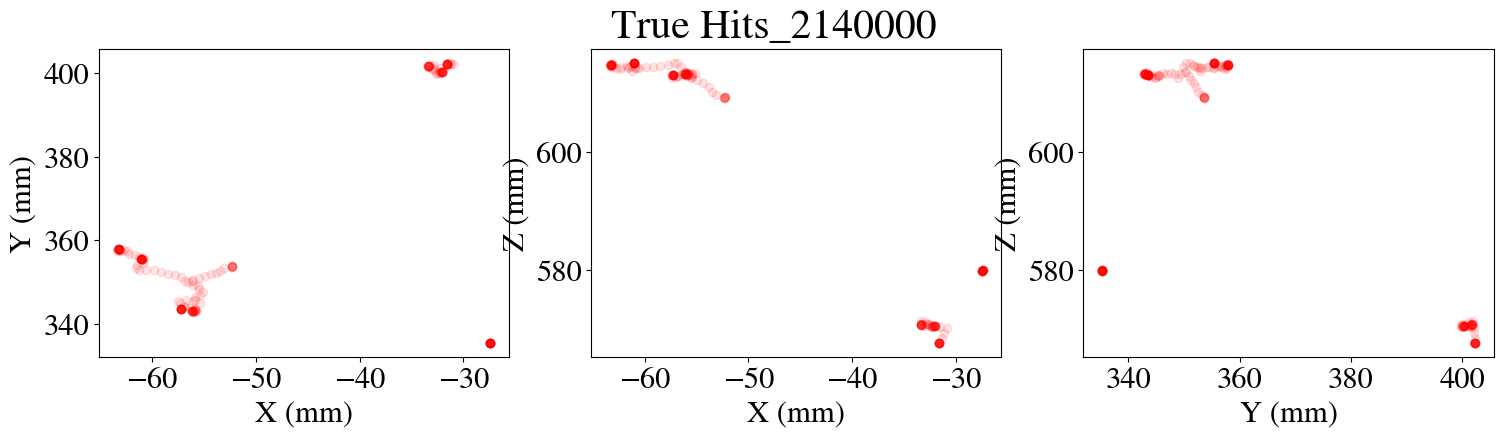

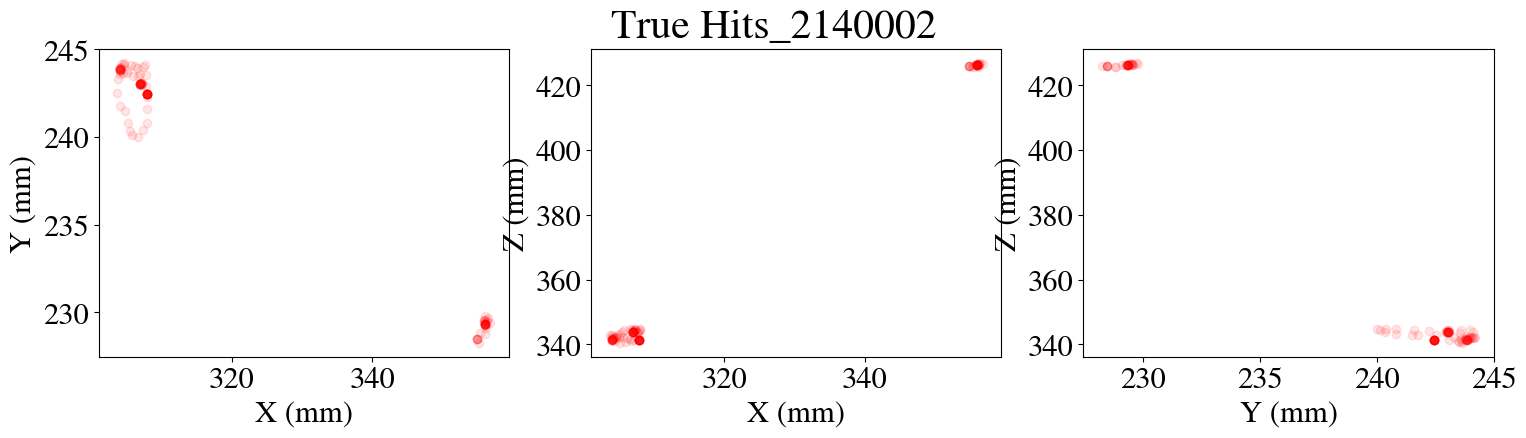

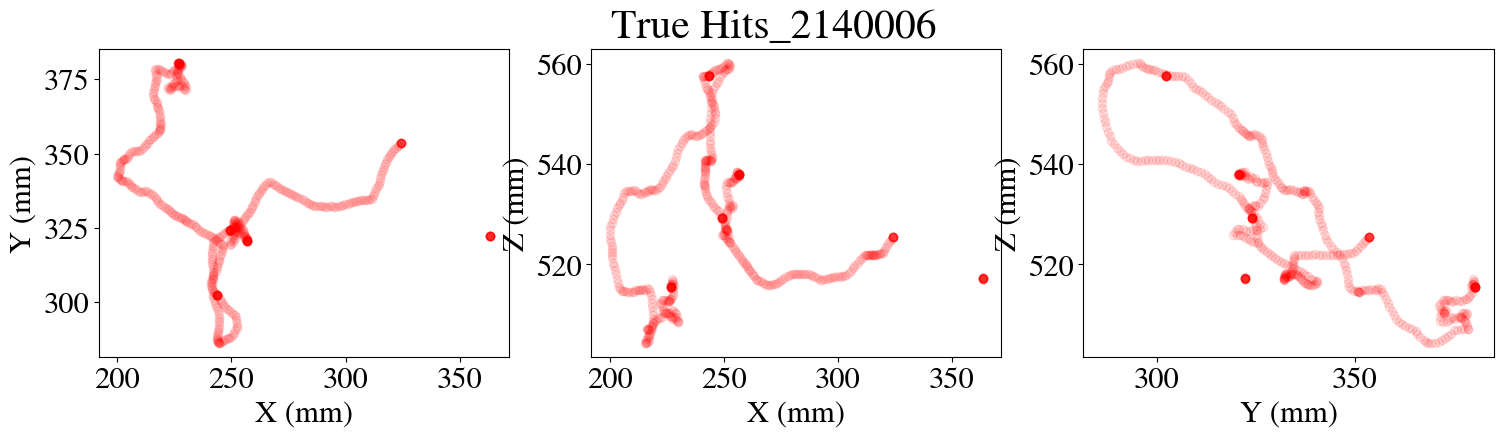

In [44]:
bck_array = [BCKEVENT1, BCKEVENT2, BCKEVENT3]
sig_array = [SIGEVENT1, SIGEVENT2, SIGEVENT3]

print("BACKGROUND EVENTS")
# background search, Q_THR 1
for i in range(len(bck_array)):

    evtmap = mcio.load_eventnumbermap(directory + soph_array[0]).set_index('nexus_evt')
    true_info = mcio.load_mchits_df(directory + soph_array[0]).reset_index()
    true_info.event_id = true_info.event_id.map(evtmap.evt_number)
    
    
    this_evt_true_info = true_info[true_info.event_id == bck_array[i]]

    xt = this_evt_true_info.x
    yt = this_evt_true_info.y
    zt = this_evt_true_info.z
    et = this_evt_true_info.energy*1000

    fig, axes = plt.subplots(1, 3, figsize=(18, 4))
    axes[0].scatter(xt, yt,  alpha=0.1, color='red')
    axes[0].set_xlabel('X (mm)');
    axes[0].set_ylabel('Y (mm)');

    axes[1].scatter(xt, zt,  alpha=0.1, color='red')
    axes[1].set_xlabel('X (mm)');
    axes[1].set_ylabel('Z (mm)');

    axes[2].scatter(yt, zt,  alpha=0.1, color='red')
    axes[2].set_xlabel('Y (mm)');
    axes[2].set_ylabel('Z (mm)');
    
    fig.suptitle('True Hits_' + str(bck_array[i]), fontsize=30)
    #fig.savefig(pre_dir_name + "/MC_hits")

SIGNAL EVENTS


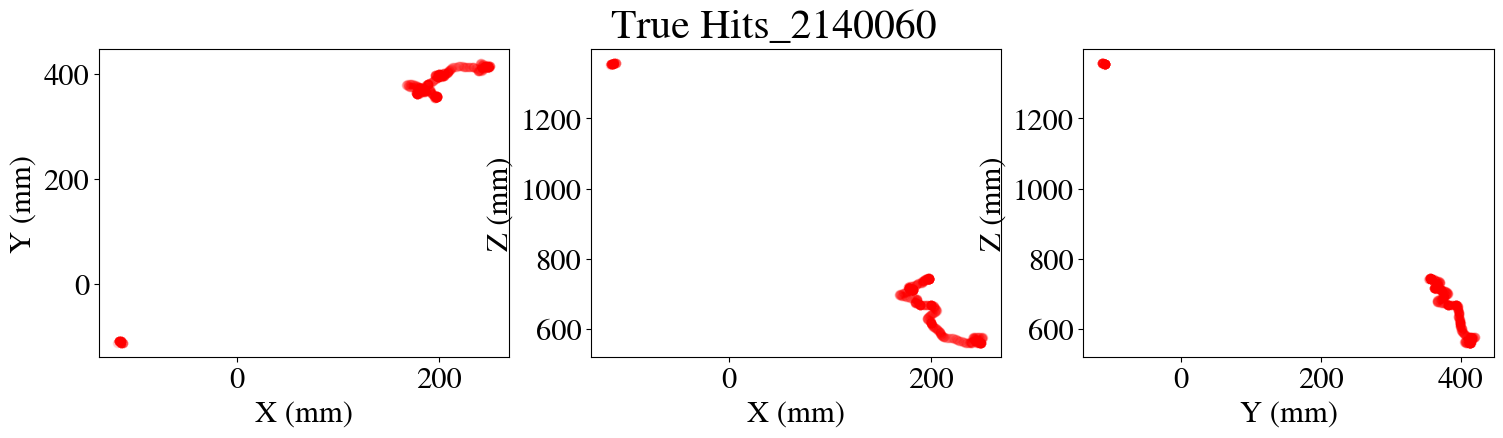

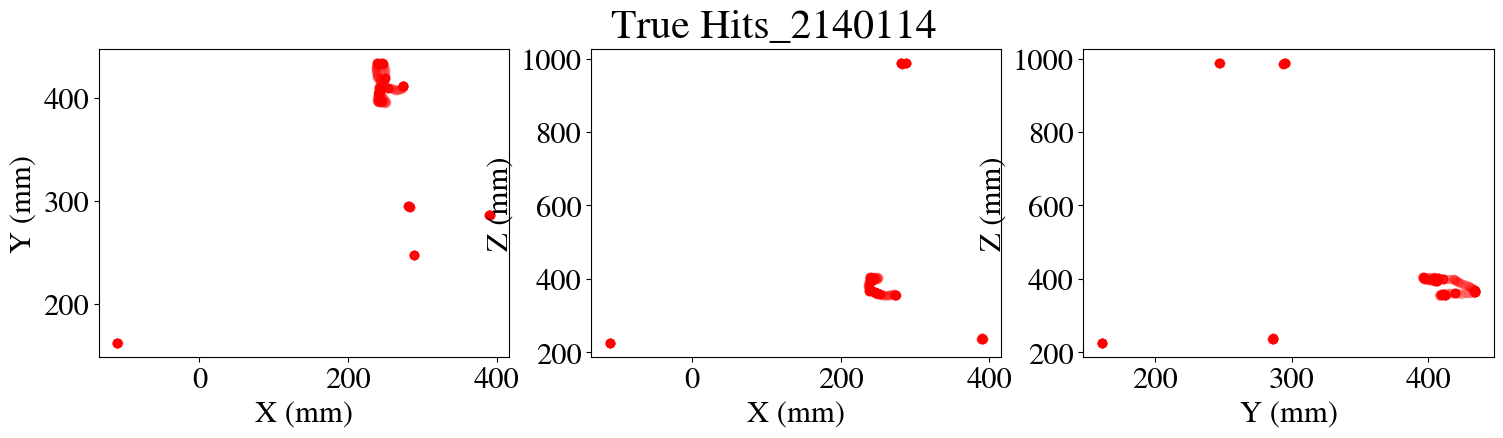

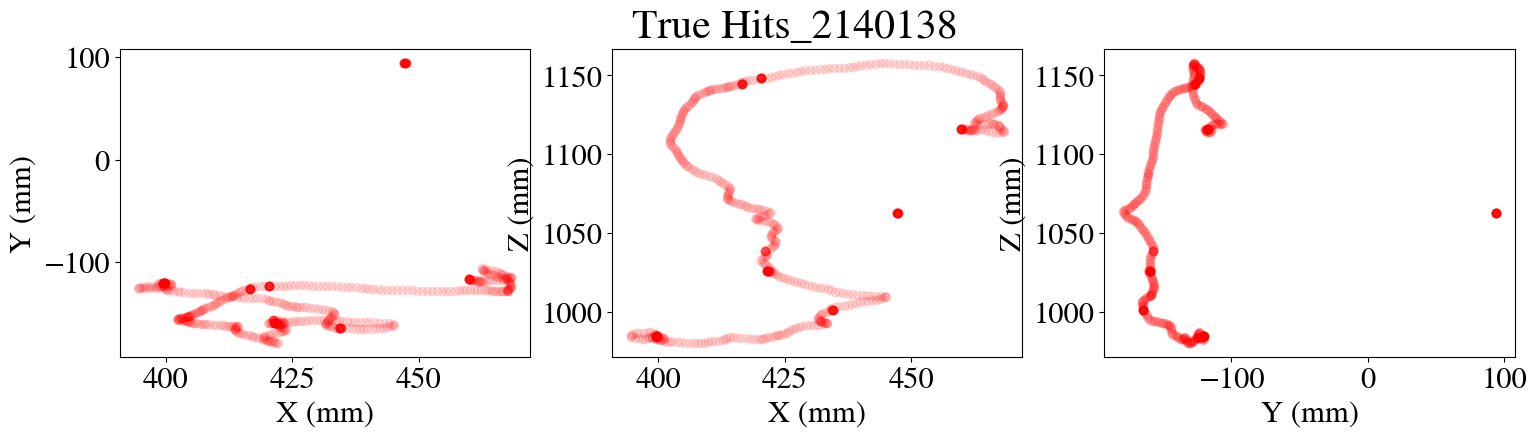

In [47]:


print("SIGNAL EVENTS")
# background search, Q_THR 1
for i in range(len(bck_array)):

    evtmap = mcio.load_eventnumbermap(directory + soph_array[0]).set_index('nexus_evt')
    true_info = mcio.load_mchits_df(directory + soph_array[0]).reset_index()
    true_info.event_id = true_info.event_id.map(evtmap.evt_number)
    
    
    this_evt_true_info = true_info[true_info.event_id == sig_array[i]]

    xt = this_evt_true_info.x
    yt = this_evt_true_info.y
    zt = this_evt_true_info.z
    et = this_evt_true_info.energy*1000

    fig, axes = plt.subplots(1, 3, figsize=(18, 4))
    axes[0].scatter(xt, yt,  alpha=0.1, color='red')
    axes[0].set_xlabel('X (mm)');
    axes[0].set_ylabel('Y (mm)');

    axes[1].scatter(xt, zt,  alpha=0.1, color='red')
    axes[1].set_xlabel('X (mm)');
    axes[1].set_ylabel('Z (mm)');

    axes[2].scatter(yt, zt,  alpha=0.1, color='red')
    axes[2].set_xlabel('Y (mm)');
    axes[2].set_ylabel('Z (mm)');
    
    fig.suptitle('True Hits_' + str(sig_array[i]), fontsize=30)
    #fig.savefig(pre_dir_name + "/MC_hits")

### PLOT SOPHRONIA OUTPUT ACROSS THESE FILES

First (due to the refactoring) we need to convert these to low threshold events

In [49]:
lowTh_QTHR1 = soph_to_lowTh(qthr1, threshold= 1, verbose = False)
lowTh_QTHR3 = soph_to_lowTh(qthr3, threshold= 3, verbose = False)
lowTh_QTHR5 = soph_to_lowTh(qthr5, threshold= 5, verbose = False)

In [ ]:
def create_plot(file, event_number):
    '''
    create sophronia plot from the file and event number provided
    needs to be lowTh file :)
    '''